In [1]:
from __future__ import print_function, division  

import os, sys

import codecs
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils

from torchvision.transforms import ToTensor

RawPath = 'D:\\GitWork\\mnist\\raw\\'
# ProcessedPath = 'D:\\GitWork\\mnist\\processed\\'

In [2]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16).copy()
        return torch.from_numpy(parsed).view(length, num_rows, num_cols)
    
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8).copy()
        return torch.from_numpy(parsed).view(length).long()

    
class myMnistDataset(Dataset):
    
    Resources = {
        'train': [ "train-images-idx3-ubyte", "train-labels-idx1-ubyte" ],
        'valid' : [ "t10k-images-idx3-ubyte",  "t10k-labels-idx1-ubyte" ]
    }
    
    def __init__(self, path, train=True, transform=None, debug=True):
        self.datapath = path
        self.train = train
        self.transform = transform
        
        datafiles = self.Resources['train'] if self.train else self.Resources['valid']
        images = read_image_file(os.path.join(self.datapath, datafiles[0]))
        labels = read_label_file(os.path.join(self.datapath, datafiles[1]))
        
        if debug: 
            phase = 'train' if self.train else 'valid'
            print('phase: {}'.format(phase))
            print('type:')
            print('  ', type(images))
            print('  ', type(labels))
            print('shape:')
            print('  ', images.shape)
            print('  ', labels.shape)
            print()

        self.len = len(images)
        self.imgs = images
        self.lbls = labels
  
    def __getitem__(self, index):
        img, lbl = self.imgs[index], int(self.lbls[index])
        
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, lbl
                          
    def __len__(self):
        return self.len
    
    @property
    def images(self):
        return self.imgs

    @property
    def labels(self):
        return self.lbls


In [3]:
# Prepare dataset and dataloader

# Create transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3801,))
])

# Create datasets
trainSet = myMnistDataset(path=RawPath, train=True, transform=transform)
validSet = myMnistDataset(path=RawPath, train=False, transform=transform)

phase: train
type:
   <class 'torch.Tensor'>
   <class 'torch.Tensor'>
shape:
   torch.Size([60000, 28, 28])
   torch.Size([60000])

phase: valid
type:
   <class 'torch.Tensor'>
   <class 'torch.Tensor'>
shape:
   torch.Size([10000, 28, 28])
   torch.Size([10000])



In [4]:
# Create dataloaders
BatchSize = 100

trainLoader = DataLoader(
    dataset=trainSet, batch_size=BatchSize, shuffle=True
)

validLoader = DataLoader(
    dataset=validSet, batch_size=BatchSize, shuffle=False
)

image:
 tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,

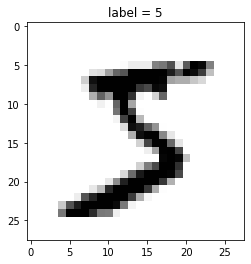

In [5]:
def imgshow(img, lbl):
    lbl_str = str(lbl.numpy())
    plt.title("label = {}".format(lbl_str))
    
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='binary')
    plt.show()
    
img = trainSet.images[0]
lbl = trainSet.labels[0]
print('image:\n', img); print('\nlabel: ',lbl)

imgshow(img, lbl)

In [6]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print('GPU State:', device)

GPU State: cuda:0


In [7]:
# Model

class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)

input_size = 784
hidden_size1 = 128
hidden_size2 = 64
num_classes = 10
    
net = Net(input_size, hidden_size1, hidden_size2, num_classes).to(device)
print(net)

Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax()
  )
)


In [8]:
# Parameters
epochs = 3
learning_rate = 0.002
criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# Train
for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(trainLoader):
        images, labels = data[0].to(device), data[1].to(device)
        images = images.view(images.shape[0], -1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Foward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % BatchSize == 0 or i+1 == len(trainLoader):
            print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, i+1, len(trainLoader), running_loss/2000))


[1/3, 100/600] loss: 0.108
[1/3, 200/600] loss: 0.173
[1/3, 300/600] loss: 0.205
[1/3, 400/600] loss: 0.230
[1/3, 500/600] loss: 0.250
[1/3, 600/600] loss: 0.269
[2/3, 100/600] loss: 0.018
[2/3, 200/600] loss: 0.034
[2/3, 300/600] loss: 0.050
[2/3, 400/600] loss: 0.065
[2/3, 500/600] loss: 0.081
[2/3, 600/600] loss: 0.095
[3/3, 100/600] loss: 0.014
[3/3, 200/600] loss: 0.027
[3/3, 300/600] loss: 0.041
[3/3, 400/600] loss: 0.053
[3/3, 500/600] loss: 0.066
[3/3, 600/600] loss: 0.079


In [9]:
# Test
correct = 0
total = 0

with torch.no_grad():
    for data in validLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))

class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

with torch.no_grad():
    for data in validLoader:
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.view(inputs.shape[0], -1)

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            print(class_correct)
            print(class_total)

for i in range(10):
    print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))

Accuracy of the network on the 10000 test images: 92 %
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 1, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 0]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 1]
[1, 2, 1, 0, 2, 0, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 0, 1, 0, 2]
[1, 2, 1, 0, 2, 0, 1, 1, 0, 2]
[1, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 0, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 2, 2, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 1, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 2, 1, 1, 0, 2]
[2, 2, 1, 0, 3, 1, 1, 1, 0, 3]
[2, 2, 1, 0, 3, 2, 1, 1, 0, 3]
[2, 2, 1, 0, 3,

[14, 20, 16, 12, 16, 8, 12, 12, 9, 18]
[14, 20, 16, 15, 18, 11, 12, 14, 13, 19]
[14, 20, 16, 12, 16, 8, 12, 12, 10, 18]
[14, 20, 16, 15, 18, 11, 12, 14, 14, 19]
[14, 20, 16, 13, 16, 8, 12, 12, 10, 18]
[14, 20, 16, 16, 18, 11, 12, 14, 14, 19]
[15, 20, 16, 13, 16, 8, 12, 12, 10, 18]
[15, 20, 16, 16, 18, 11, 12, 14, 14, 19]
[15, 20, 16, 13, 16, 8, 12, 13, 10, 18]
[15, 20, 16, 16, 18, 11, 12, 15, 14, 19]
[15, 20, 17, 13, 16, 8, 12, 13, 10, 18]
[15, 20, 17, 16, 18, 11, 12, 15, 14, 19]
[15, 20, 17, 13, 16, 8, 12, 14, 10, 18]
[15, 20, 17, 16, 18, 11, 12, 16, 14, 19]
[15, 20, 17, 13, 16, 8, 12, 14, 10, 19]
[15, 20, 17, 16, 18, 11, 12, 16, 14, 20]
[15, 20, 17, 13, 17, 8, 12, 14, 10, 19]
[15, 20, 17, 16, 19, 11, 12, 16, 14, 20]
[15, 20, 17, 14, 17, 8, 12, 14, 10, 19]
[15, 20, 17, 17, 19, 11, 12, 16, 14, 20]
[15, 20, 17, 15, 17, 8, 12, 14, 10, 19]
[15, 20, 17, 18, 19, 11, 12, 16, 14, 20]
[15, 20, 17, 15, 17, 8, 13, 14, 10, 19]
[15, 20, 17, 18, 19, 11, 13, 16, 14, 20]
[15, 21, 17, 15, 17, 8, 13, 1

[28, 34, 28, 30, 38, 20, 24, 29, 22, 26]
[28, 34, 29, 36, 41, 23, 25, 32, 27, 30]
[28, 34, 28, 30, 38, 20, 24, 29, 22, 26]
[28, 34, 29, 36, 41, 23, 25, 32, 27, 31]
[28, 34, 28, 30, 38, 20, 24, 29, 22, 27]
[28, 34, 29, 36, 41, 23, 25, 32, 27, 32]
[28, 34, 28, 30, 38, 21, 24, 29, 22, 27]
[28, 34, 29, 36, 41, 24, 25, 32, 27, 32]
[28, 34, 28, 30, 38, 21, 24, 29, 22, 28]
[28, 34, 29, 36, 41, 24, 25, 32, 27, 33]
[28, 34, 28, 30, 38, 21, 24, 30, 22, 28]
[28, 34, 29, 36, 41, 24, 25, 33, 27, 33]
[28, 34, 28, 30, 38, 22, 24, 30, 22, 28]
[28, 34, 29, 36, 41, 25, 25, 33, 27, 33]
[28, 34, 28, 30, 38, 22, 24, 31, 22, 28]
[28, 34, 29, 36, 41, 25, 25, 34, 27, 33]
[28, 34, 28, 30, 38, 23, 24, 31, 22, 28]
[28, 34, 29, 36, 41, 26, 25, 34, 27, 33]
[28, 34, 28, 30, 38, 23, 24, 32, 22, 28]
[28, 34, 29, 36, 41, 26, 25, 35, 27, 33]
[28, 34, 28, 31, 38, 23, 24, 32, 22, 28]
[28, 34, 29, 37, 41, 26, 25, 35, 27, 33]
[28, 34, 29, 31, 38, 23, 24, 32, 22, 28]
[28, 34, 30, 37, 41, 26, 25, 35, 27, 33]
[28, 34, 30, 31,

[40, 48, 45, 42, 42, 29, 39, 47, 35, 40]
[40, 50, 47, 49, 46, 37, 41, 52, 41, 49]
[40, 48, 45, 42, 42, 29, 39, 47, 35, 41]
[40, 50, 47, 49, 46, 37, 41, 52, 41, 50]
[40, 48, 46, 42, 42, 29, 39, 47, 35, 41]
[40, 50, 48, 49, 46, 37, 41, 52, 41, 50]
[40, 48, 47, 42, 42, 29, 39, 47, 35, 41]
[40, 50, 49, 49, 46, 37, 41, 52, 41, 50]
[40, 48, 47, 42, 42, 29, 39, 47, 35, 42]
[40, 50, 49, 49, 46, 37, 41, 52, 41, 51]
[40, 48, 48, 42, 42, 29, 39, 47, 35, 42]
[40, 50, 50, 49, 46, 37, 41, 52, 41, 51]
[40, 49, 48, 42, 42, 29, 39, 47, 35, 42]
[40, 51, 50, 49, 46, 37, 41, 52, 41, 51]
[40, 49, 48, 42, 42, 29, 39, 47, 36, 42]
[40, 51, 50, 49, 46, 37, 41, 52, 42, 51]
[40, 49, 48, 43, 42, 29, 39, 47, 36, 42]
[40, 51, 50, 50, 46, 37, 41, 52, 42, 51]
[40, 49, 48, 44, 42, 29, 39, 47, 36, 42]
[40, 51, 50, 51, 46, 37, 41, 52, 42, 51]
[40, 49, 48, 44, 42, 29, 39, 47, 36, 42]
[40, 51, 50, 51, 46, 37, 41, 52, 43, 51]
[40, 50, 48, 44, 42, 29, 39, 47, 36, 42]
[40, 52, 50, 51, 46, 37, 41, 52, 43, 51]
[40, 51, 48, 44,

[54, 65, 60, 60, 55, 40, 54, 56, 49, 60]
[54, 67, 62, 68, 60, 48, 56, 62, 59, 70]
[54, 65, 60, 60, 55, 40, 54, 57, 49, 60]
[54, 67, 62, 68, 60, 48, 56, 63, 59, 70]
[54, 65, 60, 60, 55, 40, 54, 58, 49, 60]
[54, 67, 62, 68, 60, 48, 56, 64, 59, 70]
[54, 66, 60, 60, 55, 40, 54, 58, 49, 60]
[54, 68, 62, 68, 60, 48, 56, 64, 59, 70]
[54, 66, 60, 61, 55, 40, 54, 58, 49, 60]
[54, 68, 62, 69, 60, 48, 56, 64, 59, 70]
[54, 66, 60, 61, 56, 40, 54, 58, 49, 60]
[54, 68, 62, 69, 61, 48, 56, 64, 59, 70]
[54, 67, 60, 61, 56, 40, 54, 58, 49, 60]
[54, 69, 62, 69, 61, 48, 56, 64, 59, 70]
[54, 67, 60, 61, 57, 40, 54, 58, 49, 60]
[54, 69, 62, 69, 62, 48, 56, 64, 59, 70]
[54, 67, 60, 62, 57, 40, 54, 58, 49, 60]
[54, 69, 62, 70, 62, 48, 56, 64, 59, 70]
[54, 67, 60, 62, 57, 40, 55, 58, 49, 60]
[54, 69, 62, 70, 62, 48, 57, 64, 59, 70]
[54, 67, 60, 62, 57, 40, 55, 59, 49, 60]
[54, 69, 62, 70, 62, 48, 57, 65, 59, 70]
[54, 67, 61, 62, 57, 40, 55, 59, 49, 60]
[54, 69, 63, 70, 62, 48, 57, 65, 59, 70]
[54, 67, 61, 63,

[64, 85, 76, 77, 70, 52, 70, 71, 63, 74]
[64, 87, 79, 85, 75, 61, 72, 77, 75, 85]
[64, 86, 76, 77, 70, 52, 70, 71, 63, 74]
[64, 88, 79, 85, 75, 61, 72, 77, 75, 85]
[65, 86, 76, 77, 70, 52, 70, 71, 63, 74]
[65, 88, 79, 85, 75, 61, 72, 77, 75, 85]
[65, 86, 76, 77, 70, 53, 70, 71, 63, 74]
[65, 88, 79, 85, 75, 62, 72, 77, 75, 85]
[65, 86, 76, 77, 70, 53, 70, 71, 64, 74]
[65, 88, 79, 85, 75, 62, 72, 77, 76, 85]
[65, 86, 77, 77, 70, 53, 70, 71, 64, 74]
[65, 88, 80, 85, 75, 62, 72, 77, 76, 85]
[65, 86, 77, 77, 70, 53, 70, 72, 64, 74]
[65, 88, 80, 85, 75, 62, 72, 78, 76, 85]
[65, 86, 77, 77, 70, 53, 70, 73, 64, 74]
[65, 88, 80, 85, 75, 62, 72, 79, 76, 85]
[66, 86, 77, 77, 70, 53, 70, 73, 64, 74]
[66, 88, 80, 85, 75, 62, 72, 79, 76, 85]
[66, 87, 77, 77, 70, 53, 70, 73, 64, 74]
[66, 89, 80, 85, 75, 62, 72, 79, 76, 85]
[66, 87, 78, 77, 70, 53, 70, 73, 64, 74]
[66, 89, 81, 85, 75, 62, 72, 79, 76, 85]
[66, 87, 78, 77, 70, 53, 70, 73, 64, 75]
[66, 89, 81, 85, 75, 62, 72, 79, 76, 86]
[66, 87, 78, 77,

[75, 106, 91, 90, 81, 61, 81, 93, 76, 92]
[75, 108, 94, 101, 87, 70, 83, 99, 89, 103]
[75, 106, 91, 90, 81, 61, 81, 93, 76, 92]
[75, 108, 94, 101, 87, 70, 83, 100, 89, 103]
[75, 106, 91, 91, 81, 61, 81, 93, 76, 92]
[75, 108, 94, 102, 87, 70, 83, 100, 89, 103]
[75, 106, 91, 91, 81, 61, 81, 94, 76, 92]
[75, 108, 94, 102, 87, 70, 83, 101, 89, 103]
[75, 106, 91, 91, 82, 61, 81, 94, 76, 92]
[75, 108, 94, 102, 88, 70, 83, 101, 89, 103]
[75, 106, 91, 91, 83, 61, 81, 94, 76, 92]
[75, 108, 94, 102, 89, 70, 83, 101, 89, 103]
[75, 106, 91, 91, 84, 61, 81, 94, 76, 92]
[75, 108, 94, 102, 90, 70, 83, 101, 89, 103]
[76, 106, 91, 91, 84, 61, 81, 94, 76, 92]
[76, 108, 94, 102, 90, 70, 83, 101, 89, 103]
[76, 106, 91, 92, 84, 61, 81, 94, 76, 92]
[76, 108, 94, 103, 90, 70, 83, 101, 89, 103]
[76, 106, 91, 92, 84, 61, 81, 94, 77, 92]
[76, 108, 94, 103, 90, 70, 83, 101, 90, 103]
[76, 106, 91, 92, 84, 61, 81, 95, 77, 92]
[76, 108, 94, 103, 90, 70, 83, 102, 90, 103]
[76, 106, 91, 92, 84, 62, 81, 95, 77, 92]
[7